## **K Nearest Neighbors**


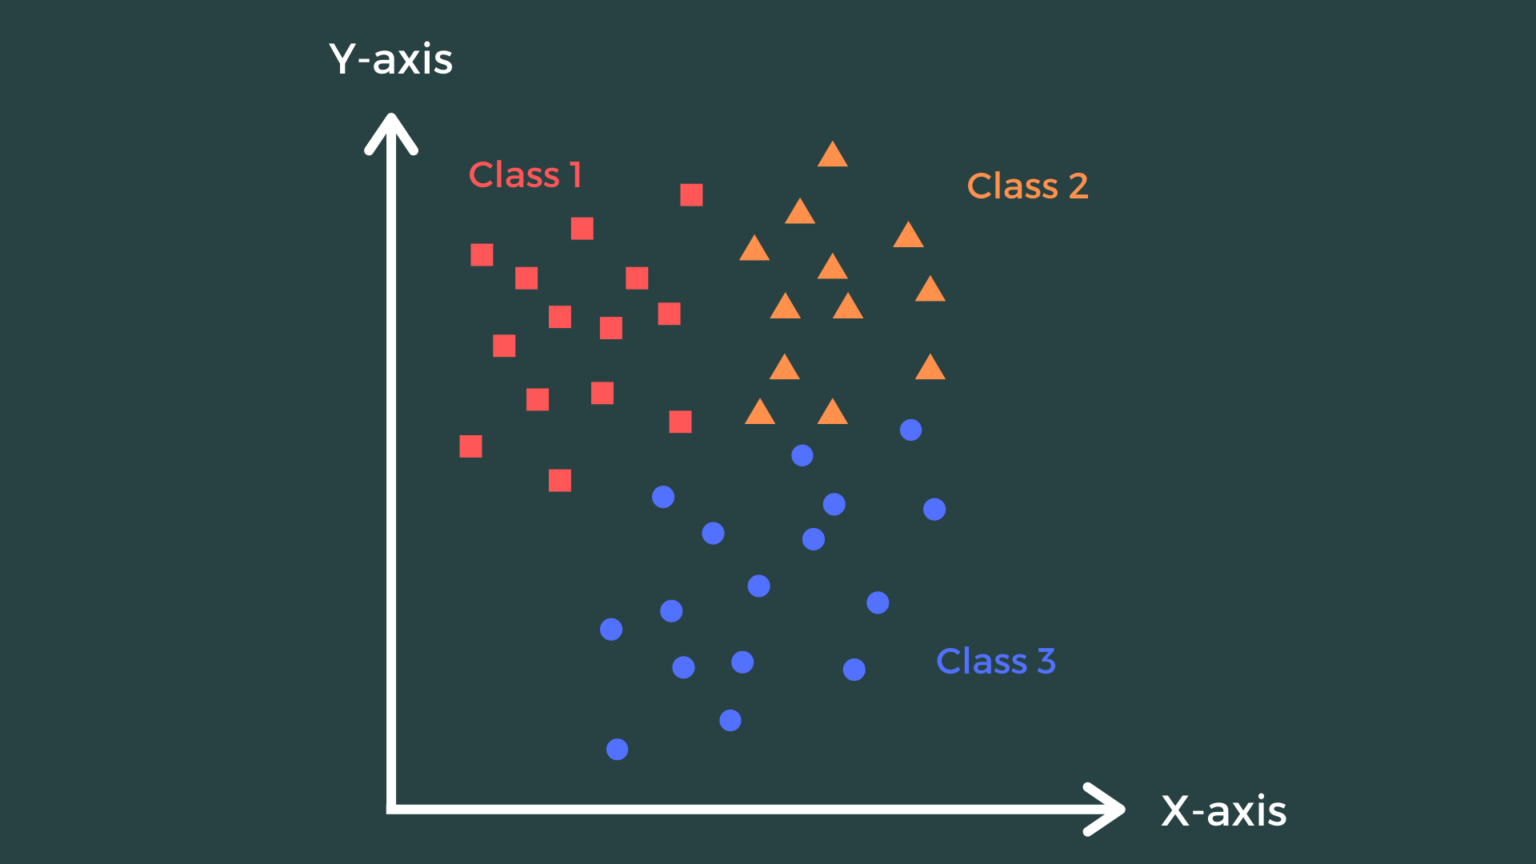

#### The **K-Nearest Neighbor (KNN)** algorithm is a popular machine learning technique used for classification and regression tasks. It relies on the idea that similar data points tend to have similar labels or values.

#### **During the training phase:**
 - KNN algorithm stores the entire training dataset as a reference.

#### **When making predictions:**
  **1.** It calculates the distance between the input data point and all the training examples, using a chosen distance metric such as Euclidean distance.

  **2.** Next, the algorithm identifies the K nearest neighbors to the input data point based on their distances.
   - **Classification -** The algorithm assigns the most common class label among the K neighbors as the predicted label for the input data point.
   - **Regression -** It calculates the average or weighted average of the target values of the K neighbors to predict the value for the input data point.

We can also assign weights to K nearest Kneighbors which weigh points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.



### **KNN Regression**


In [ ]:
class KNeighborsRegressor:

  def __init__(self, n_neighbors = 5, weights = 'uniform', distance_metric = 'euclidean'):
    if weights not in {'uniform', 'distance'}:
      raise Exception('The argument passed for "weights" should be either "uniform" or "distance"')
    if distance_metric not in {'euclidean', 'manhattan'}:
      raise Exception('The distance metric passed should be either "euclidean" or "manhattan"')
    self.n_neighbors = n_neighbors
    self.weights = weights
    self.distance_metric = distance_metric


  def fit(self, X, y):
    self.X = X
    self.y = y


  def predict(self, X):
    import warnings
    warnings.filterwarnings('ignore')
    import numpy as np
    import pandas as pd
    y_pred = []
    for x in X:
      if self.distance_metric == 'euclidean':
        distances = np.sqrt(np.sum((x - self.X) ** 2, axis = 1))
      else:
        distances = np.sum(np.abs(x - self.X), axis = 1)
      sorted_indexes = np.argsort(distances)
      neighbors_sorted_distances = distances[sorted_indexes]
      k_nearest_neighbor_distances = neighbors_sorted_distances[ :self.n_neighbors]
      k_nearest_neighbor_indexes = sorted_indexes[ :self.n_neighbors]
      k_nearest_neighbor_y = self.y[k_nearest_neighbor_indexes]
      if self.weights == 'uniform':
        weights = [(1/self.n_neighbors)] * self.n_neighbors
      else:
        weights = 1/k_nearest_neighbor_distances
        if (np.isinf(weights)).any():
          pred = np.mean(k_nearest_neighbor_y[np.isinf(weights)])
        else:
          weights = weights/(np.sum(weights))
          pred = np.average(k_nearest_neighbor_y, weights = weights)
      y_pred.append(pred)
    y_pred = np.array(y_pred)
    return y_pred


  def kneighbors(self, X, n_neighbors = 5, return_distances = True):
    import warnings
    warnings.filterwarnings('ignore')
    import numpy as np
    import pandas as pd
    neigh_dist = []
    neigh_ind = []
    for x in X:
      if self.distance_metric == 'euclidean':
        distances = np.sqrt(np.sum((x - self.X) ** 2, axis = 1))
      else:
        distances = np.sum(np.abs(x - self.X), axis = 1)
      sorted_indexes = np.argsort(distances)
      neighbors_sorted_distances = distances[sorted_indexes]
      k_nearest_neighbor_distances = neighbors_sorted_distances[ :self.n_neighbors]
      k_nearest_neighbor_indexes = sorted_indexes[ :self.n_neighbors]
      neigh_dist.append(k_nearest_neighbor_distances)
      neigh_ind.append(k_nearest_neighbor_indexes)
    neigh_dist = np.array(neigh_dist)
    neigh_ind = np.array(neigh_ind)
    if return_distances:
      return neigh_dist, neigh_ind
    else:
      return neigh_ind


  def score(self, X, y_true):
    import warnings
    warnings.filterwarnings('ignore')
    import numpy as np
    import pandas as pd
    y_pred = self.predict(X)
    rss = np.sum((y_true - y_pred) ** 2)
    tss = np.sum((y_true - y_true.mean()) ** 2)
    r2_score = 1 - rss/tss
    return r2_score

### **KNN Classification**


In [ ]:
class KNeighborsClassifier:

  def __init__(self, n_neighbors = 5, weights = 'uniform', distance_metric = 'euclidean'):
    if weights not in {'uniform', 'distance'}:
      raise Exception('The argument passed for "weights" should be either "uniform" or "distance"')
    if distance_metric not in {'euclidean', 'manhattan'}:
      raise Exception('The distance metric passed should be either "euclidean" or "manhattan"')
    self.n_neighbors = n_neighbors
    self.weights = weights
    self.distance_metric = distance_metric


  def fit(self, X, y):
    import warnings
    warnings.filterwarnings('ignore')
    import numpy as np
    import pandas as pd
    self.X = X
    self.y = y


  def predict(self, X):
    import warnings
    warnings.filterwarnings('ignore')
    import numpy as np
    import pandas as pd
    all_classes = np.array(pd.unique(self.y))
    all_classes.sort()
    probas = self.predict_proba(X)
    max_proba_class_index = np.argmax(probas, axis = 1)
    y_pred = all_classes[max_proba_class_index]
    return y_pred


  def predict_proba(self, X):
    import warnings
    warnings.filterwarnings('ignore')
    import numpy as np
    import pandas as pd
    probas = []
    for x in X:
      if self.distance_metric == 'euclidean':
        distances = np.sqrt(np.sum((x - self.X) ** 2, axis = 1))
      else:
        distances = np.sum(np.abs(x - self.X), axis = 1)
      sorted_indexes = np.argsort(distances)
      neighbors_sorted_distances = distances[sorted_indexes]
      k_nearest_neighbor_distances = neighbors_sorted_distances[ :self.n_neighbors]
      k_nearest_neighbor_indexes = sorted_indexes[ :self.n_neighbors]
      k_nearest_neighbor_y = self.y[k_nearest_neighbor_indexes]
      class_frequencies = pd.value_counts(k_nearest_neighbor_y).to_frame(name = 'frequency')
      all_classes = np.reshape(sorted(pd.unique(self.y)), (-1, 1))
      all_classes_df = pd.DataFrame(all_classes, columns = ['class'])
      class_frequencies = all_classes_df.merge(class_frequencies, how = 'left', left_on = 'class', right_index = True)
      class_frequencies.fillna({'frequency': 0}, inplace = True)
      class_frequencies.sort_values('class', inplace = True)

      if self.weights == 'uniform':
        class_probas = class_frequencies / np.sum(class_frequencies)

      else:
        weights = 1/k_nearest_neighbor_distances
        if (np.isinf(weights)).any():
          zero_distance_neighbor_ys = k_nearest_neighbor_y[np.isinf(weights)]
          pred = np.random.choice(zero_distance_neighbor_ys)
          pred_class_index = np.where(all_classes == pred)[0][0]
          class_probas = np.zeros(len(all_classes))
          class_probas[pred_class_index] = 1

        else:
          class_probas = weights / np.sum(weights)
          class_col = k_nearest_neighbor_y.reshape(-1, 1)
          proba_col = class_probas.reshape(-1, 1)
          class_proba_df = pd.DataFrame(data = np.hstack((class_col, proba_col)), columns = ['class', 'proba'])
          class_proba_df = class_proba_df.groupby('class').agg(proba = ('proba', 'sum')).reset_index()
          class_proba_df = all_classes_df.merge(class_proba_df, how = 'left', on = 'class')
          class_proba_df.fillna({'proba': 0}, inplace = True)
          class_probas = np.array(class_proba_df['proba'])

      probas.append(class_probas)
    probas = np.array(probas)
    return probas


  def kneighbors(self, X, n_neighbors = 5, return_distances = True):
    import warnings
    warnings.filterwarnings('ignore')
    import numpy as np
    import pandas as pd
    neigh_dist = []
    neigh_ind = []
    for x in X:
      if self.distance_metric == 'euclidean':
        distances = np.sqrt(np.sum((x - self.X) ** 2, axis = 1))
      else:
        distances = np.sum(np.abs(x - self.X), axis = 1)
      sorted_indexes = np.argsort(distances)
      neighbors_sorted_distances = distances[sorted_indexes]
      k_nearest_neighbor_distances = neighbors_sorted_distances[ :self.n_neighbors]
      k_nearest_neighbor_indexes = sorted_indexes[ :self.n_neighbors]
      neigh_dist.append(k_nearest_neighbor_distances)
      neigh_ind.append(k_nearest_neighbor_indexes)
    neigh_dist = np.array(neigh_dist)
    neigh_ind = np.array(neigh_ind)
    if return_distances:
      return neigh_dist, neigh_ind
    else:
      return neigh_ind


  def score(self, X, y_true):
    import warnings
    warnings.filterwarnings('ignore')
    import numpy as np
    import pandas as pd
    n = len(y_true)
    y_pred = self.predict(X)
    acc = (y_true == y_pred).sum()/n
    return acc